# **Happy Customers**
---

# Setup

In [45]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.feature_selection import RFE
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_curve, auc, precision_recall_curve, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from bayes_opt import BayesianOptimization
import warnings

# Suppress deprecation warnings
warnings.filterwarnings('ignore', category=FutureWarning)

# Load the data from a CSV file
dataset = pd.read_csv('ACME-HappinessSurvey2020.csv')

# Extract the input features (x) and output (y) from the dataset
x = dataset.iloc[:, 1:].values
y = dataset.iloc[:, 0].values

# Split the data into training and testing sets
random_state = 137
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.20, random_state=random_state)

# Exploratory Data Analysis

Y     0
X1    0
X2    0
X3    0
X4    0
X5    0
X6    0
dtype: int64


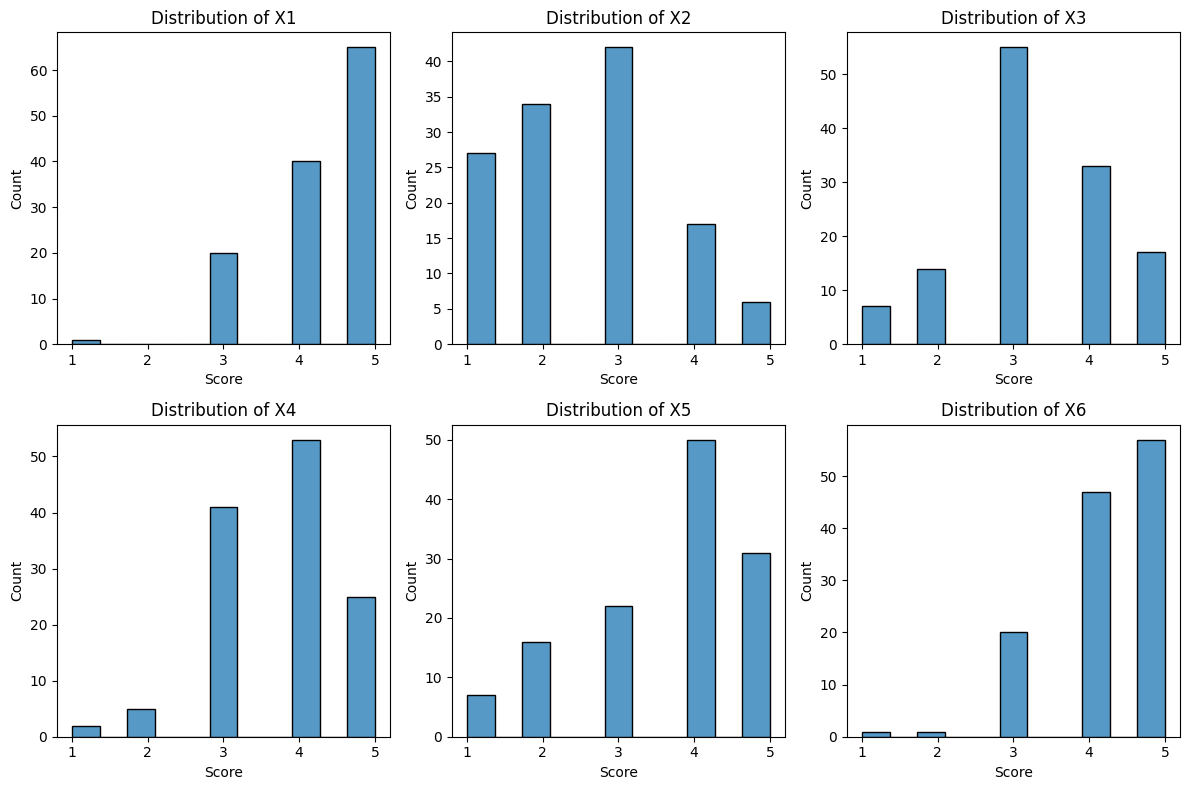

In [2]:
# Create a DataFrame with the feature columns
df_features = pd.DataFrame(x, columns=['X1', 'X2', 'X3', 'X4', 'X5', 'X6'])

# Check for missing values in the dataset
missing_values = dataset.isnull().sum()

# Print the missing values count for each column
print(missing_values)

# Plot the distribution of scores for each feature
fig, axes = plt.subplots(2, 3, figsize=(12, 8))
axes = axes.flatten()

for i, feature in enumerate(df_features.columns):
    sns.histplot(df_features[feature], ax=axes[i])
    axes[i].set_title(f'Distribution of {feature}')
    axes[i].set_xlabel('Score')
    axes[i].set_ylabel('Count')

plt.tight_layout()
plt.show()

### Outlier Detection - IQR (Interquartile Range)

Number of outliers: 17


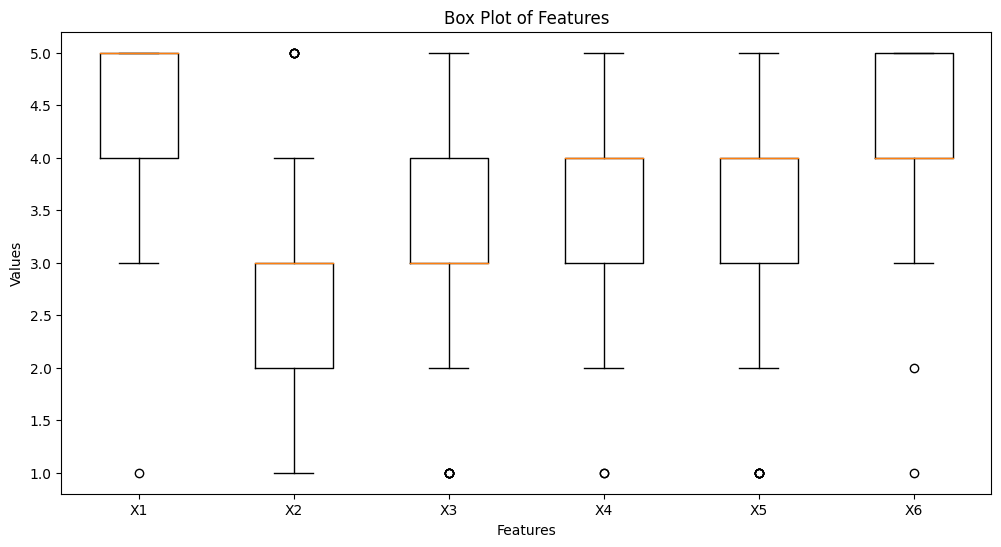

In [3]:
# Calculate the IQR
Q1 = np.percentile(x, 25, axis=0)
Q3 = np.percentile(x, 75, axis=0)
IQR = Q3 - Q1

# Define the outlier threshold
outlier_threshold = 1.5

# Find outliers
lower_bound = Q1 - outlier_threshold * IQR
upper_bound = Q3 + outlier_threshold * IQR
outliers = ((x < lower_bound) | (x > upper_bound)).any(axis=1)

# Count the number of outliers
num_outliers = sum(outliers)
print("Number of outliers:", num_outliers)


# Create box plots for each feature
plt.figure(figsize=(12, 6))
plt.boxplot(x)
plt.xticks(range(1, len(dataset.columns)), dataset.columns[1:])
plt.xlabel("Features")
plt.ylabel("Values")
plt.title("Box Plot of Features")
plt.show()

### Correlation Matrix

If the correlation between features is 0.85 or above, it will be highlighted in yellow.

In [4]:
# Calculate the correlation matrix
corr_matrix = dataset.iloc[:, 1:].corr()

# Highlight correlations above the threshold
corr_styled = corr_matrix.style.applymap(lambda x: 'background-color: yellow' if abs(x) >= 0.85 else '')

# Display the styled correlation matrix
corr_styled

,X1,X2,X3,X4,X5,X6
X1,1.000000,0.059797,0.283358,0.087541,0.432772,0.411873
X2,0.059797,1.000000,0.184129,0.114838,0.039996,-0.062205
X3,0.283358,0.184129,1.000000,0.302618,0.358397,0.203750
X4,0.087541,0.114838,0.302618,1.000000,0.293115,0.215888
X5,0.432772,0.039996,0.358397,0.293115,1.000000,0.320195
X6,0.411873,-0.062205,0.203750,0.215888,0.320195,1.000000


# Initial Modelling

In [5]:
def runModels(models, model_names, x_train, x_test, y_train, y_test):
    # Create subplots for confusion matrices and ROC curves
    fig, axes = plt.subplots(2, 4, figsize=(16, 8))
    # Iterate over models
    for i, model in enumerate(models):
        # Train the model
        model.fit(x_train, y_train)
        
        # Make predictions
        y_pred = model.predict(x_test)
        y_pred_prob = model.predict_proba(x_test)[:, 1]
        
        # Calculate scores
        accuracy = accuracy_score(y_test, y_pred)
        precision = precision_score(y_test, y_pred)
        recall = recall_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred)
        
        # Compute confusion matrix
        #cm = confusion_matrix(y_test, y_pred)
        
        # Plot confusion matrix - NEW
        ConfusionMatrixDisplay.from_predictions(y_test, y_pred, ax=axes[0, i])
        axes[0, i].set_title(f'{model_names[i]} Confusion Matrix')
        
        # Compute ROC curve and AUC
        fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
        roc_auc = auc(fpr, tpr)
        
        # Plot ROC curve
        axes[1, i].plot(fpr, tpr, label='ROC Curve (AUC = %0.2f)' % roc_auc)
        axes[1, i].plot([0, 1], [0, 1], 'k--')
        axes[1, i].set_xlim([0.0, 1.0])
        axes[1, i].set_ylim([0.0, 1.05])
        axes[1, i].set_xlabel('False Positive Rate')
        axes[1, i].set_ylabel('True Positive Rate')
        axes[1, i].set_title(f'{model_names[i]} ROC Curve')
        axes[1, i].legend(loc='lower right')
        axes[1, i].text(0.5, -0.25, f'Accuracy: {accuracy:.2f}', transform=axes[1, i].transAxes, ha='right')
        axes[1, i].text(0.5, -0.30, f'Precision: {precision:.2f}', transform=axes[1, i].transAxes, ha='right')
        axes[1, i].text(0.5, -0.35, f'Recall: {recall:.2f}', transform=axes[1, i].transAxes, ha='right')
        axes[1, i].text(0.5, -0.40, f'F1: {f1:.2f}', transform=axes[1, i].transAxes, ha='right')

    # Adjust spacing and layout
    plt.tight_layout()
    plt.show()

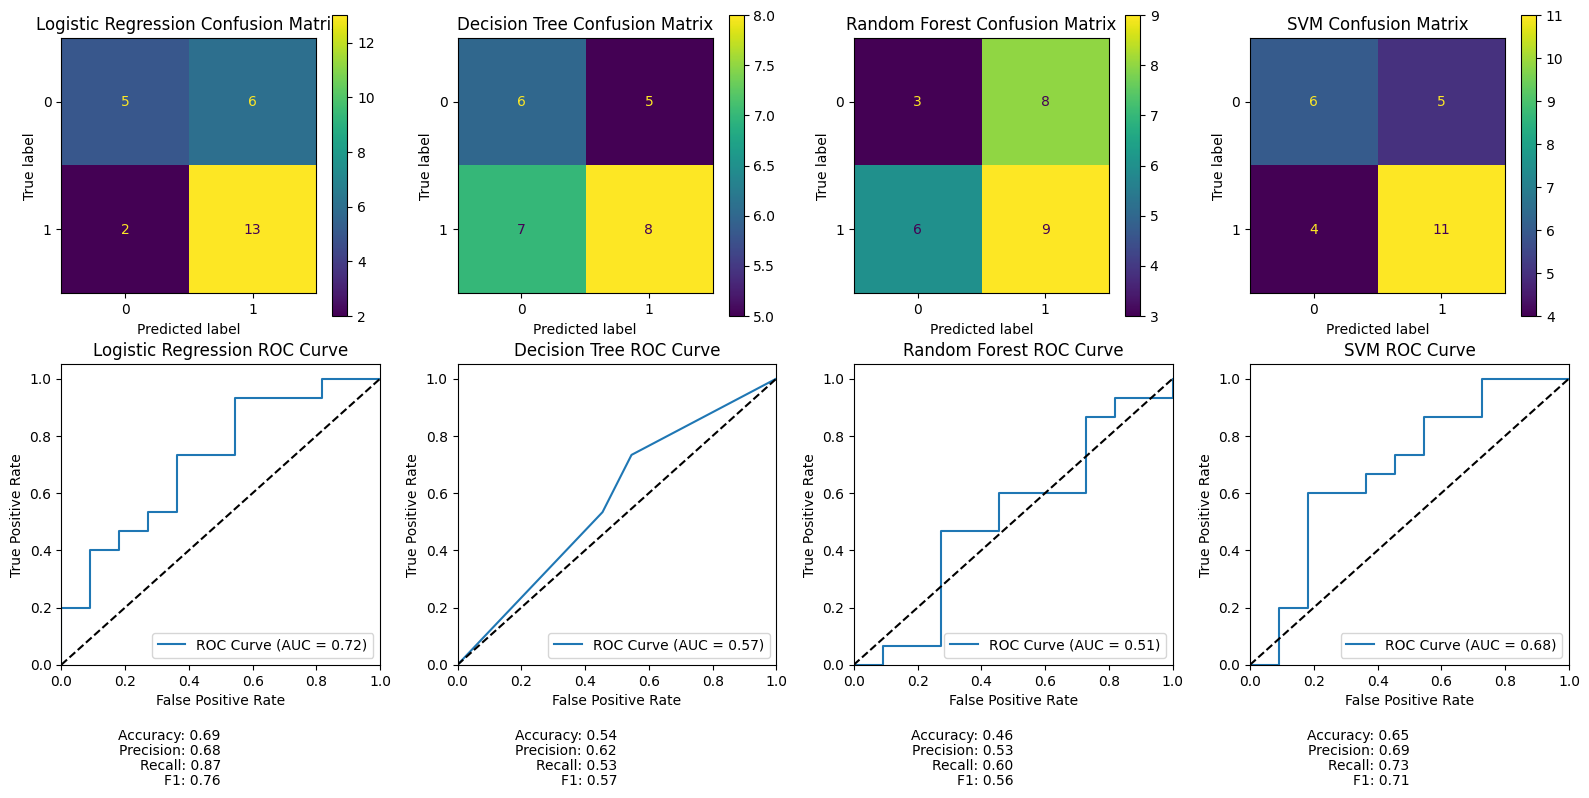

In [6]:
# Initialize the models
models = [
    LogisticRegression(),
    DecisionTreeClassifier(),
    RandomForestClassifier(),
    SVC(probability=True)
]

# Define the model names for labeling
model_names = [
    'Logistic Regression',
    'Decision Tree',
    'Random Forest',
    'SVM'
]

runModels(models, model_names, x_train, x_test, y_train, y_test)

### Analysis

Initial tests with basic models result in generally low accuracy scores. Further tuning is required.

# Optimization - Manual

## Grid Search Setup

In [7]:
def perform_grid_search(model, param_grid, x_train, y_train, cv=5, plot=False):
    grid_search = GridSearchCV(model, param_grid, cv=cv)
    grid_search.fit(x_train, y_train)

    best_params = grid_search.best_params_
    best_score = grid_search.best_score_

    print(f"Best parameters: {best_params}")
    print(f"Best score: {best_score:.2f}")

    optimized_model = model.set_params(**best_params)

    if plot:
        # Plotting the grid search results
        scores = grid_search.cv_results_['mean_test_score']
        params = grid_search.cv_results_['params']
        plot_grid_search_results(params, scores)

    return optimized_model

def plot_grid_search_results(params, scores):
    plt.figure(figsize=(10, 6))
    sns.barplot(x=scores, y=[str(param) for param in params])
    plt.xlabel('Mean Test Score')
    plt.ylabel('Hyperparameters')
    plt.title('Grid Search Results')
    plt.show()

## Logistic Regression

### Grid Search

c:\Users\danie\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\danie\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\danie\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\danie\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\danie\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the 

Best parameters: {'C': 0.01, 'max_iter': 100, 'penalty': 'l2', 'solver': 'saga'}
Best score: 0.56


c:\Users\danie\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


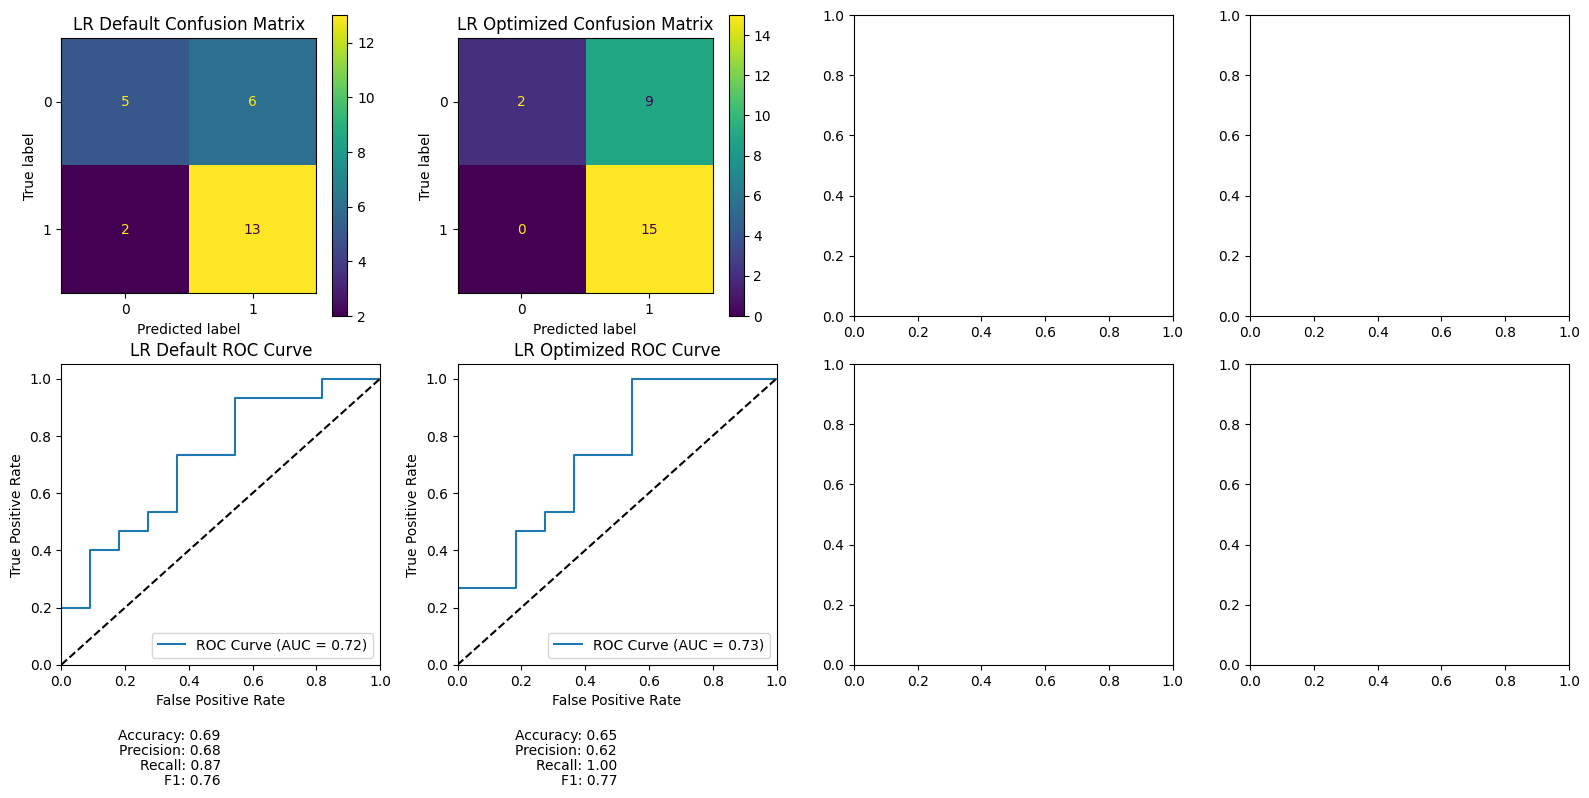

In [9]:
# Grid Search Method

# Create a Logistic Regression classifier object
model = LogisticRegression(random_state=random_state)

# Define the parameter grid
param_grid = {
    'max_iter': [100, 1000, 10000],
    'C': [0.01, 0.1, 1, 10],
    'penalty': ['l1', 'l2'],
    'solver': ['liblinear', 'lbfgs', 'saga', 'newton-cg']
}

# Perform grid search optimization
optimized_model = perform_grid_search(model, param_grid, x_train, y_train)

# Initialize the models
models = [
    LogisticRegression(random_state=random_state),
    optimized_model
]

# Define the model names for labeling
model_names = [
    'LR Default',
    'LR Optimized'
]

runModels(models, model_names, x_train, x_test, y_train, y_test)

### Regularization

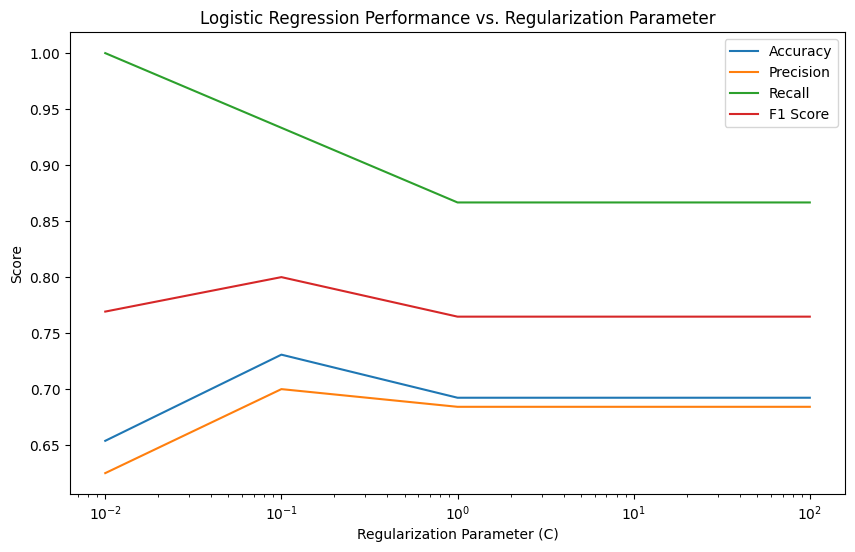

In [12]:
# Define a list of regularization parameters to evaluate
regularization_params = [0.01, 0.1, 1, 10, 100]

# Initialize empty lists to store evaluation metrics
accuracy_scores = []
precision_scores = []
recall_scores = []
f1_scores = []

# Iterate over regularization parameters
for C in regularization_params:
    # Create and train the logistic regression model
    model = LogisticRegression(C=C)
    model.fit(x_train, y_train)

    # Make predictions on the test set
    y_pred = model.predict(x_test)

    # Calculate evaluation metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)

    # Append the scores to the respective lists
    accuracy_scores.append(accuracy)
    precision_scores.append(precision)
    recall_scores.append(recall)
    f1_scores.append(f1)


# Plotting the evaluation metrics vs. regularization parameter
plt.figure(figsize=(10, 6))
plt.plot(regularization_params, accuracy_scores, label='Accuracy')
plt.plot(regularization_params, precision_scores, label='Precision')
plt.plot(regularization_params, recall_scores, label='Recall')
plt.plot(regularization_params, f1_scores, label='F1 Score')
plt.xlabel('Regularization Parameter (C)')
plt.ylabel('Score')
plt.title('Logistic Regression Performance vs. Regularization Parameter')
plt.legend()
plt.xscale('log')
plt.show()

### Applied Regularization Parameter

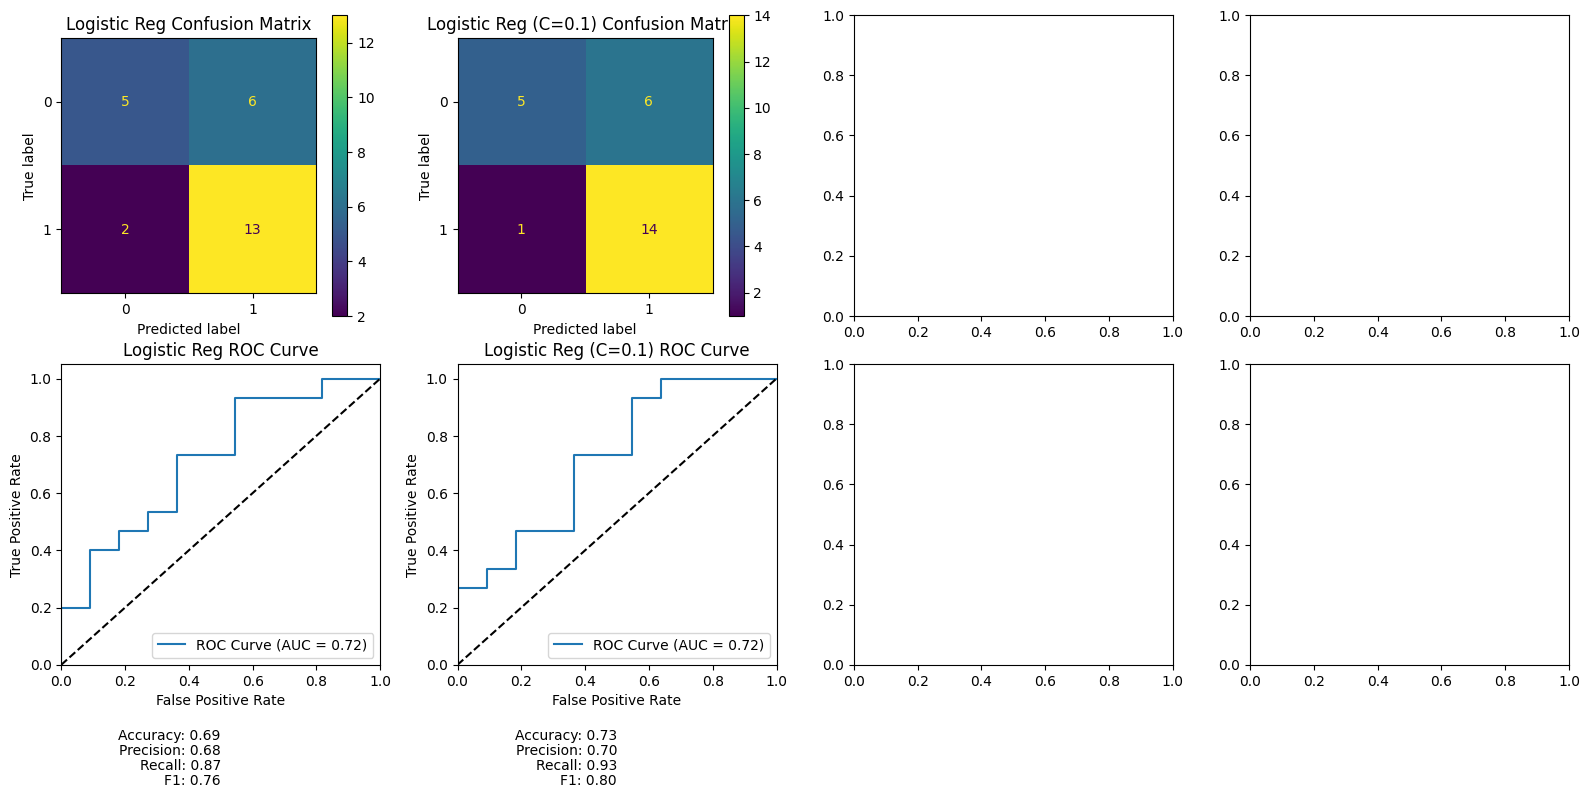

In [13]:
# Initialize the models
models = [
    LogisticRegression(),
    LogisticRegression(C=0.1)
]

# Define the model names for labeling
model_names = [
    'Logistic Reg',
    'Logistic Reg (C=0.1)'
]
runModels(models, model_names, x_train, x_test, y_train, y_test)


#### Analysis

We can determine visually that the optimal Regularization Parameter is 0.1. When applied to the LR model, Accuracy reaches the target goal of 73%.

### Feature Selection

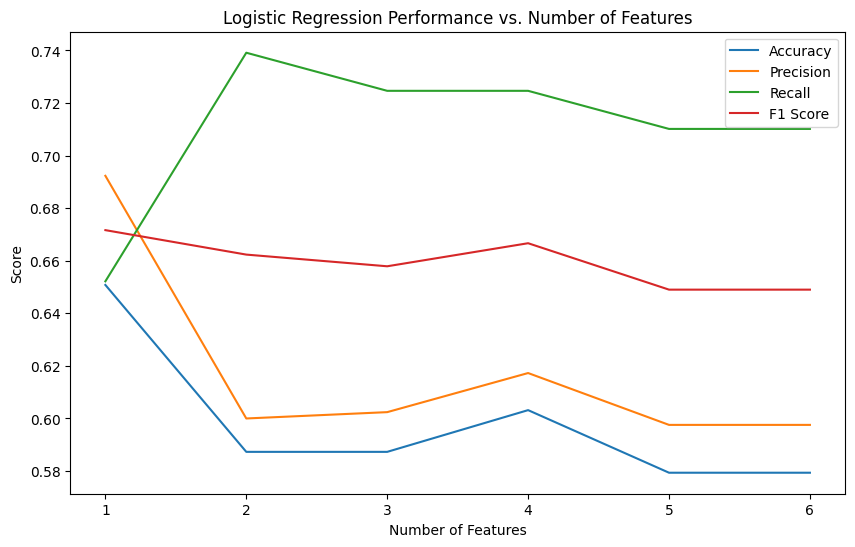

In [14]:
# Define the number of features to select
num_features = len(df_features.columns)

# Initialize empty lists to store evaluation metrics
accuracy_scores = []
precision_scores = []
recall_scores = []
f1_scores = []

# Iterate over different numbers of features
for k in range(1, num_features + 1):
    # Create a logistic regression model
    model = LogisticRegression()

    # Create RFE object and fit the model
    rfe = RFE(estimator=model, n_features_to_select=k)
    rfe.fit(df_features, y)

    # Select the top k features
    selected_features = df_features.columns[rfe.support_]

    # Train the model with the selected features
    model.fit(df_features[selected_features], y)

    # Make predictions on the test set
    y_pred = model.predict(df_features[selected_features])

    # Calculate evaluation metrics
    accuracy = accuracy_score(y, y_pred)
    precision = precision_score(y, y_pred)
    recall = recall_score(y, y_pred)
    f1 = f1_score(y, y_pred)

    # Append the scores to the respective lists
    accuracy_scores.append(accuracy)
    precision_scores.append(precision)
    recall_scores.append(recall)
    f1_scores.append(f1)

# Plotting the evaluation metrics vs. number of features
plt.figure(figsize=(10, 6))
plt.plot(range(1, num_features + 1), accuracy_scores, label='Accuracy')
plt.plot(range(1, num_features + 1), precision_scores, label='Precision')
plt.plot(range(1, num_features + 1), recall_scores, label='Recall')
plt.plot(range(1, num_features + 1), f1_scores, label='F1 Score')
plt.xlabel('Number of Features')
plt.ylabel('Score')
plt.title('Logistic Regression Performance vs. Number of Features')
plt.legend()
plt.show()

#### Analysis

This suggests that to maximize accuracy (or precision) the optimal number of features is one. Next step is to find which one is most important to keep.

Accuracy: 0.69
Precision: 0.68
Recall: 0.87
F1 Score: 0.76


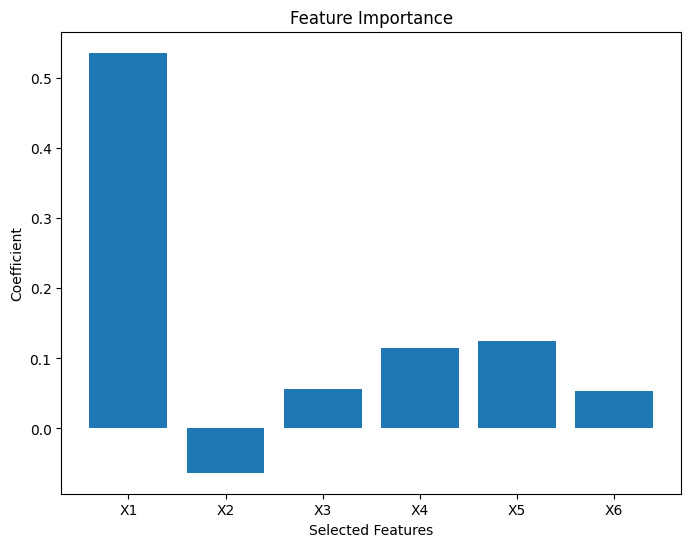

In [15]:
# Create a logistic regression model
model = LogisticRegression()

# Perform Recursive Feature Elimination (RFE)
rfe = RFE(estimator=model, n_features_to_select=6)
x_train_rfe = rfe.fit_transform(x_train, y_train)
x_test_rfe = rfe.transform(x_test)

# Fit the model to the reduced feature set
model.fit(x_train_rfe, y_train)

# Make predictions on the test set
y_pred = model.predict(x_test_rfe)

# Calculate evaluation metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

# Print the evaluation metrics
print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1 Score: {f1:.2f}")

# Get the mask of selected features
feature_mask = rfe.support_

# Get the feature names
selected_features = df_features.columns[feature_mask]

# Plotting the feature importance
plt.figure(figsize=(8, 6))
plt.bar(selected_features, rfe.estimator_.coef_.flatten())
plt.xlabel('Selected Features')
plt.ylabel('Coefficient')
plt.title('Feature Importance')
plt.show()

### Applied RFE 1

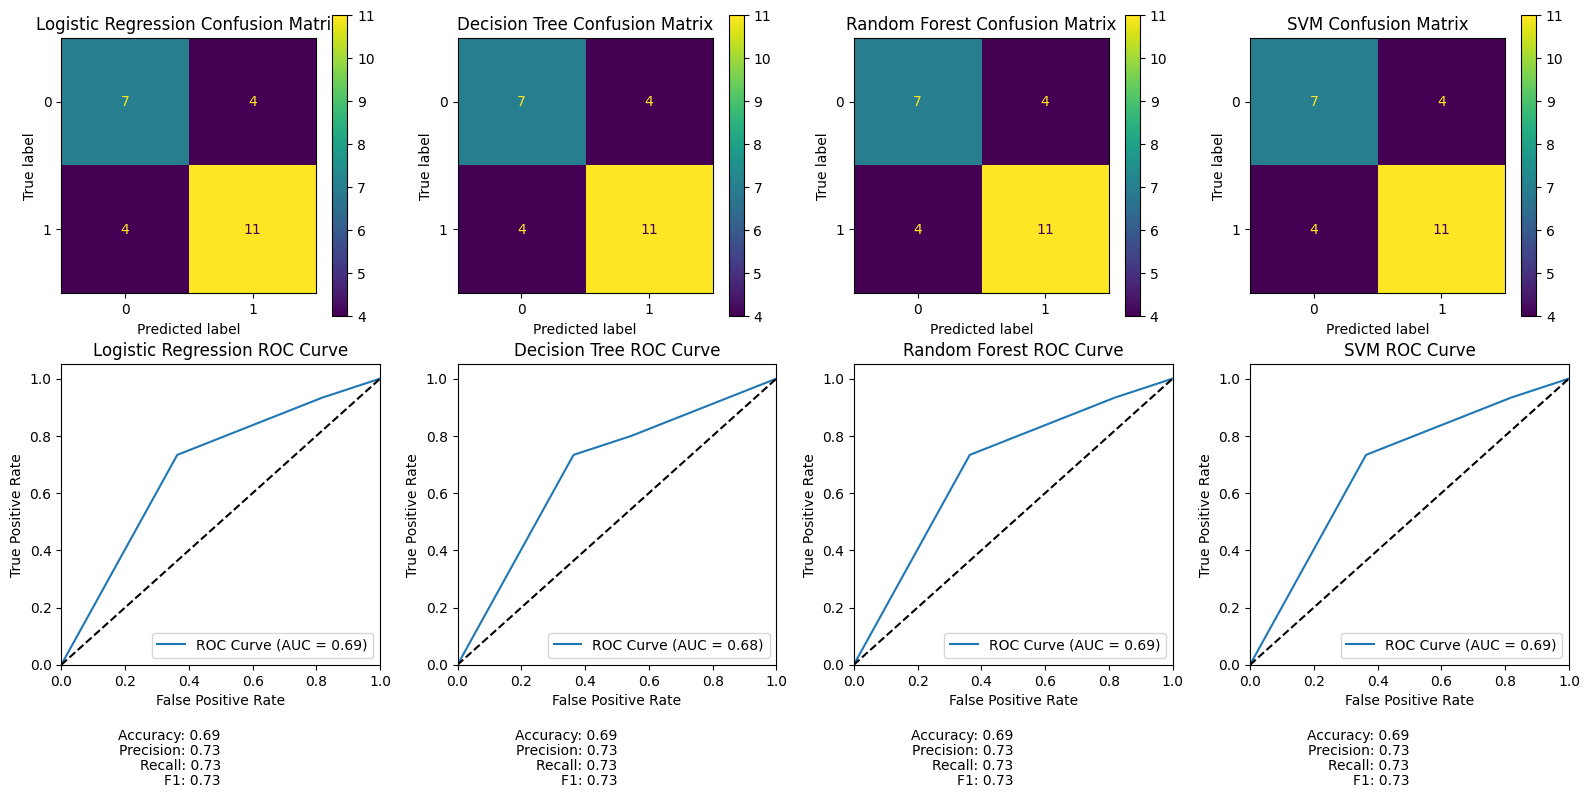

In [16]:
# Initialize the models
models = [
    LogisticRegression(),
    DecisionTreeClassifier(),
    RandomForestClassifier(),
    SVC(probability=True)
]

# Define the model names for labeling
model_names = [
    'Logistic Regression',
    'Decision Tree',
    'Random Forest',
    'SVM'
]

selected_features = ['X1']
x_selected = df_features[selected_features].values
x_train_selected, x_test_selected, y_train, y_test = train_test_split(x_selected, y, test_size=0.20, random_state= random_state)

runModels(models, model_names, x_train_selected, x_test_selected, y_train, y_test)

#### Analysis

Basing the prediction only on X1 yields better results than including all other features into the modelling. 

**Question**: Is there danger in reducing features so heavily, even if the results improve?

### Applied RFE 2

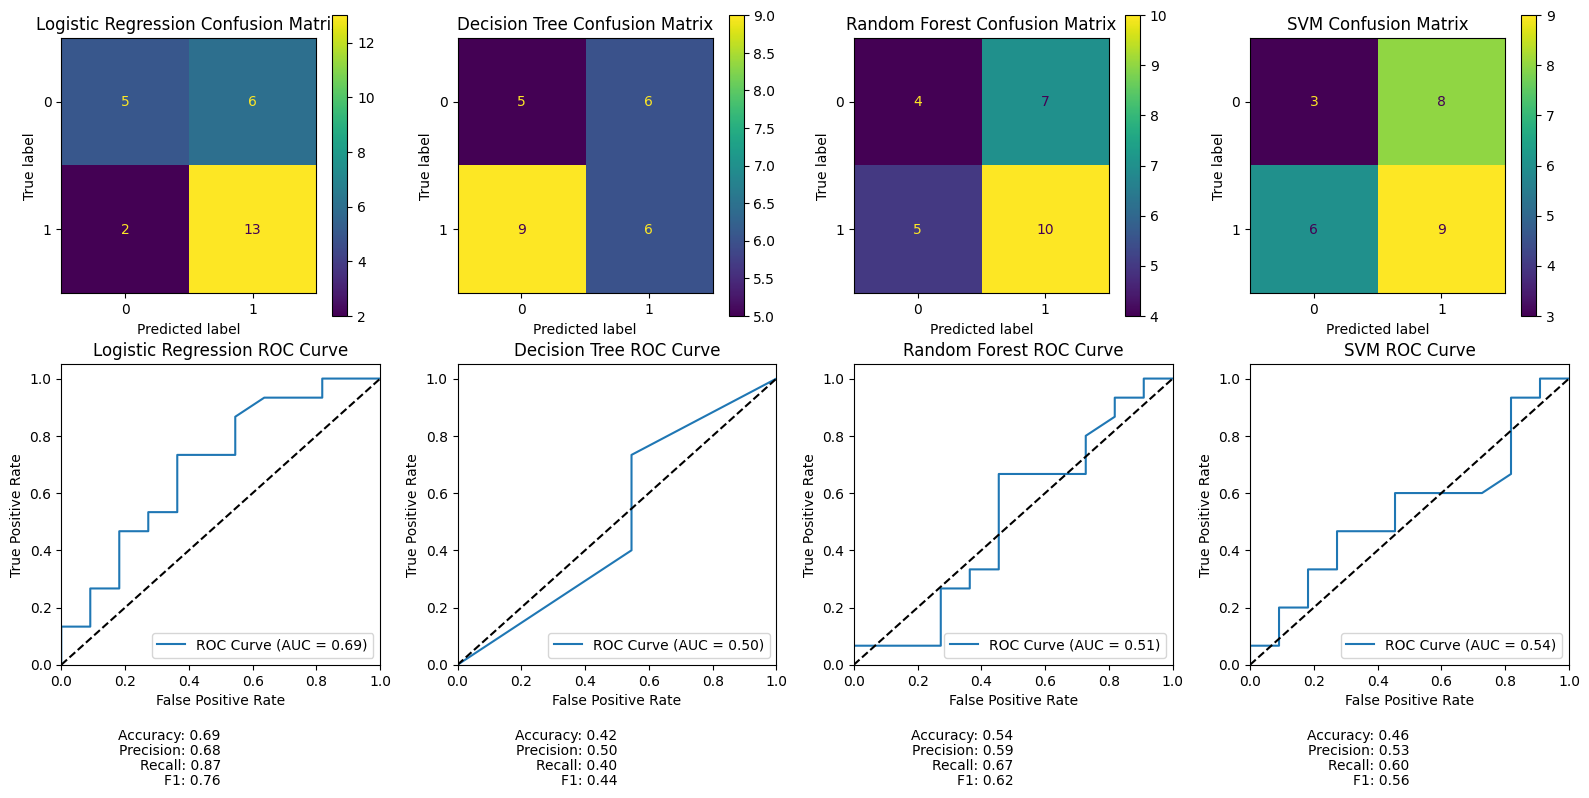

In [17]:
# Initialize the models
models = [
    LogisticRegression(),
    DecisionTreeClassifier(),
    RandomForestClassifier(),
    SVC(probability=True)
]

# Define the model names for labeling
model_names = [
    'Logistic Regression',
    'Decision Tree',
    'Random Forest',
    'SVM'
]

selected_features = ['X1', 'X3', 'X4', 'X5', 'X6']
x_selected = df_features[selected_features].values
x_train_selected, x_test_selected, y_train, y_test = train_test_split(x_selected, y, test_size=0.20, random_state= random_state)

runModels(models, model_names, x_train_selected, x_test_selected, y_train, y_test)

#### Analysis

The LR model results when excluding X2 match the results that include X2.

- **Accuracy**: no change
- **Precision**: -0.01
- **Recall**: +0.06
- **F1**: +0.02

This confirms that X2 is not an useful factor to predicting customer happiness, and can be removed from the next survey.

### Applied RP and RFE

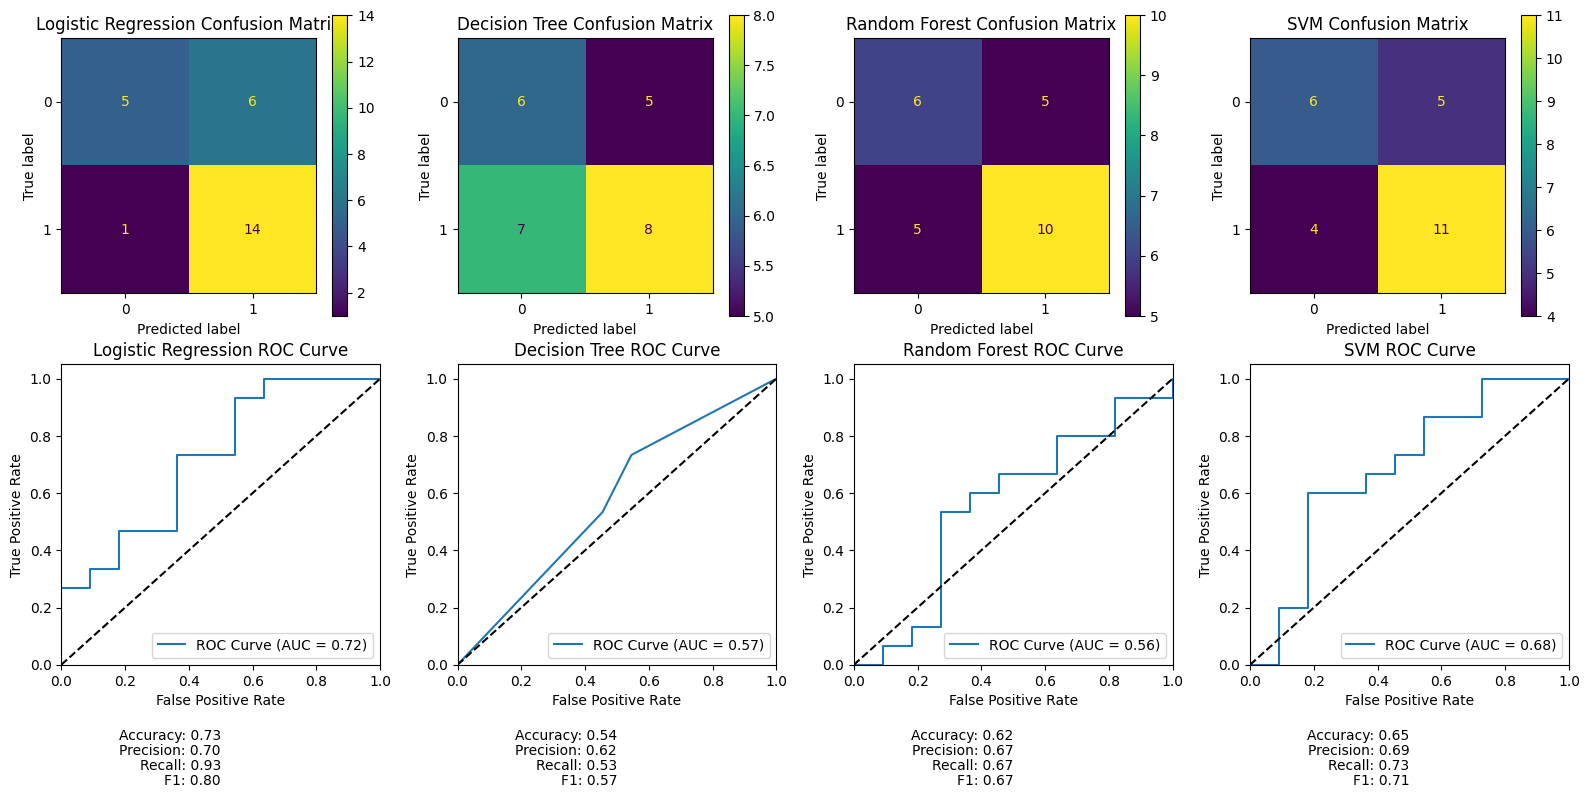

In [18]:
# Initialize the models
models = [
    LogisticRegression(C=0.1),
    DecisionTreeClassifier(),
    RandomForestClassifier(),
    SVC(probability=True)
]

# Define the model names for labeling
model_names = [
    'Logistic Regression',
    'Decision Tree',
    'Random Forest',
    'SVM'
]

selected_features = ['X1', 'X2', 'X3', 'X4', 'X5', 'X6'] # Full
#selected_features = ['X1']
#selected_features = ['X1','X3', 'X4', 'X5', 'X6'] 
#selected_features = ['X1', 'X4', 'X5'] 
x_selected = df_features[selected_features].values
x_train_selected, x_test_selected, y_train, y_test = train_test_split(x_selected, y, test_size=0.20, random_state= random_state)

runModels(models, model_names, x_train_selected, x_test_selected, y_train, y_test)

#### Analysis

Once the Regularization Parameter (C) is taken into account, X2 becomes a more important factor and cannot be removed without affecting the LR model's performance.

## Random Forests

Here I tried both a manual, visual, approach and an automated approach via **Grid Search**.

### Max Features

Best parameters: {'max_features': 'sqrt'}
Best score: 0.59


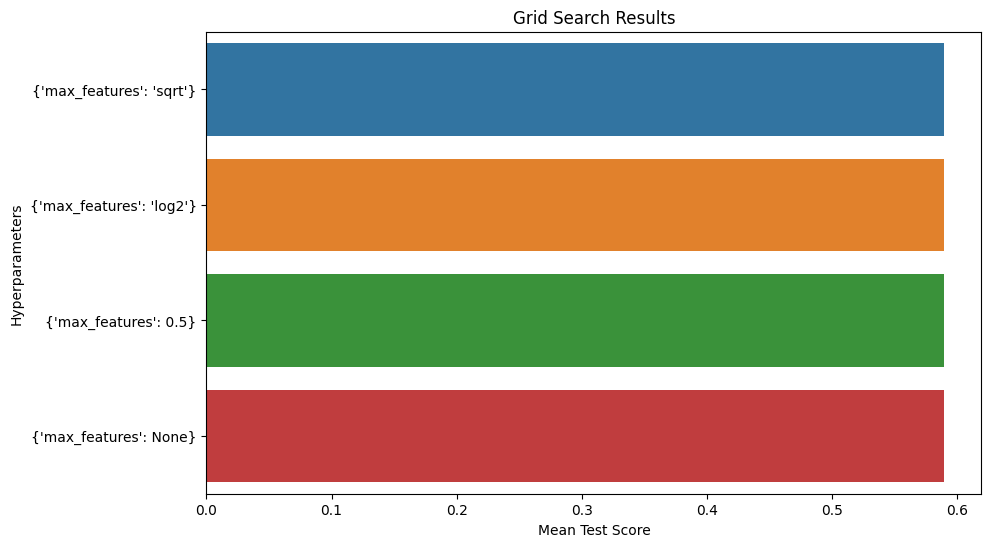

In [19]:
# Grid Search Method

# Create a Random Forest classifier object
model = RandomForestClassifier(random_state=random_state)

# Define the parameter grid
param_grid = {
    'max_features': ['sqrt', 'log2', 0.5, None]
}

# Perform grid search optimization
optimized_model = perform_grid_search(model, param_grid, x_train, y_train, plot=True)

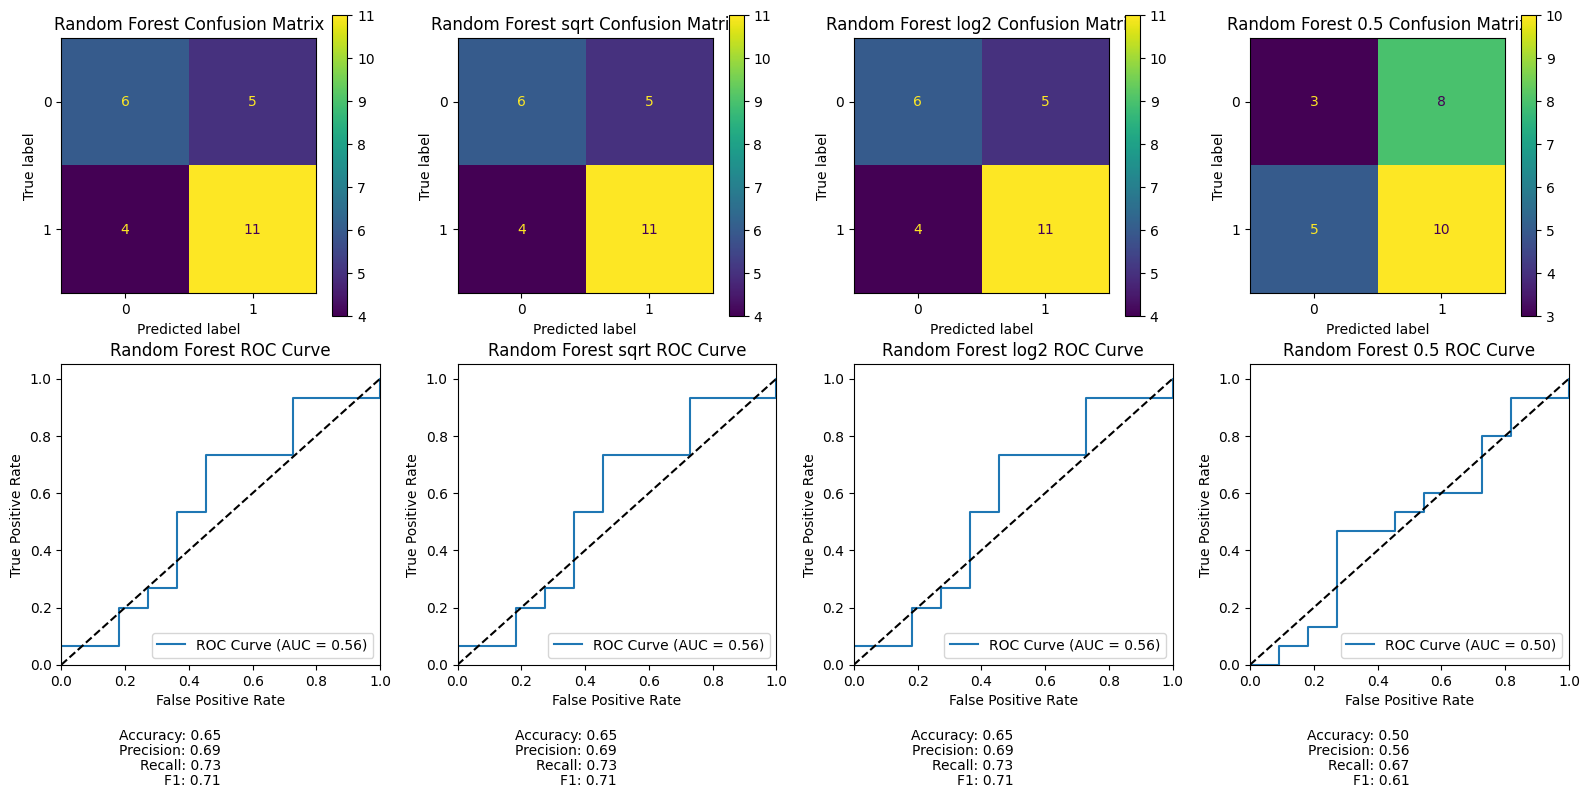

In [20]:
# Visual Method

# Initialize the models
models = [
    RandomForestClassifier(random_state=random_state),
    RandomForestClassifier(random_state=random_state, max_features= 'sqrt'),
    RandomForestClassifier(random_state=random_state, max_features= 'log2'),
    RandomForestClassifier(random_state=random_state, max_features= 0.5)
]

# Define the model names for labeling
model_names = [
    'Random Forest',
    'Random Forest sqrt',
    'Random Forest log2',
    'Random Forest 0.5'
]

runModels(models, model_names, x_train, x_test, y_train, y_test)

### Minimum Samples per Leaf

Best parameters: {'min_samples_leaf': 5}
Best score: 0.61


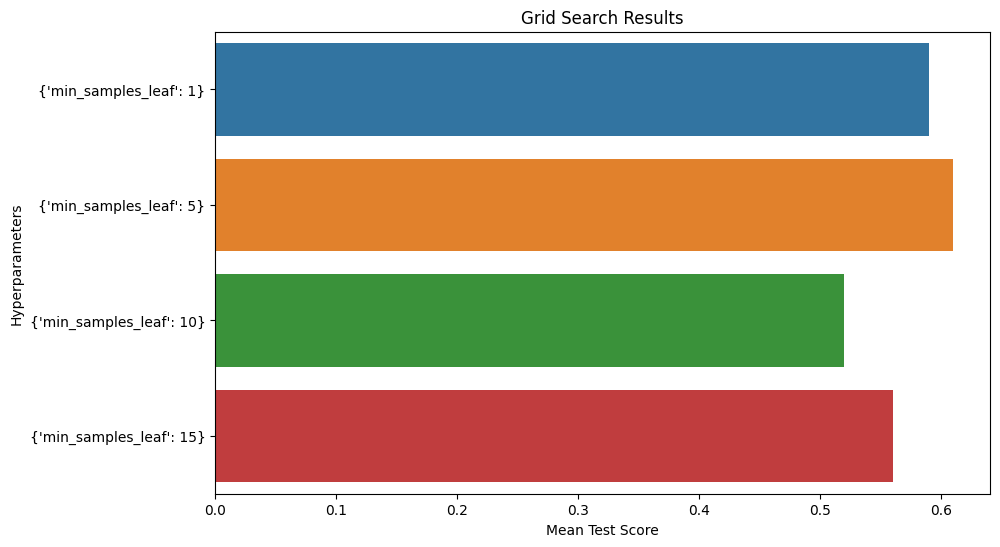

In [21]:
# Grid Search Method

# Create a Random Forest classifier object
model = RandomForestClassifier(random_state=random_state)

# Define the parameter grid
param_grid = {
    'min_samples_leaf': [1, 5, 10, 15]
}

# Perform grid search optimization
optimized_model = perform_grid_search(model, param_grid, x_train, y_train, plot=True)

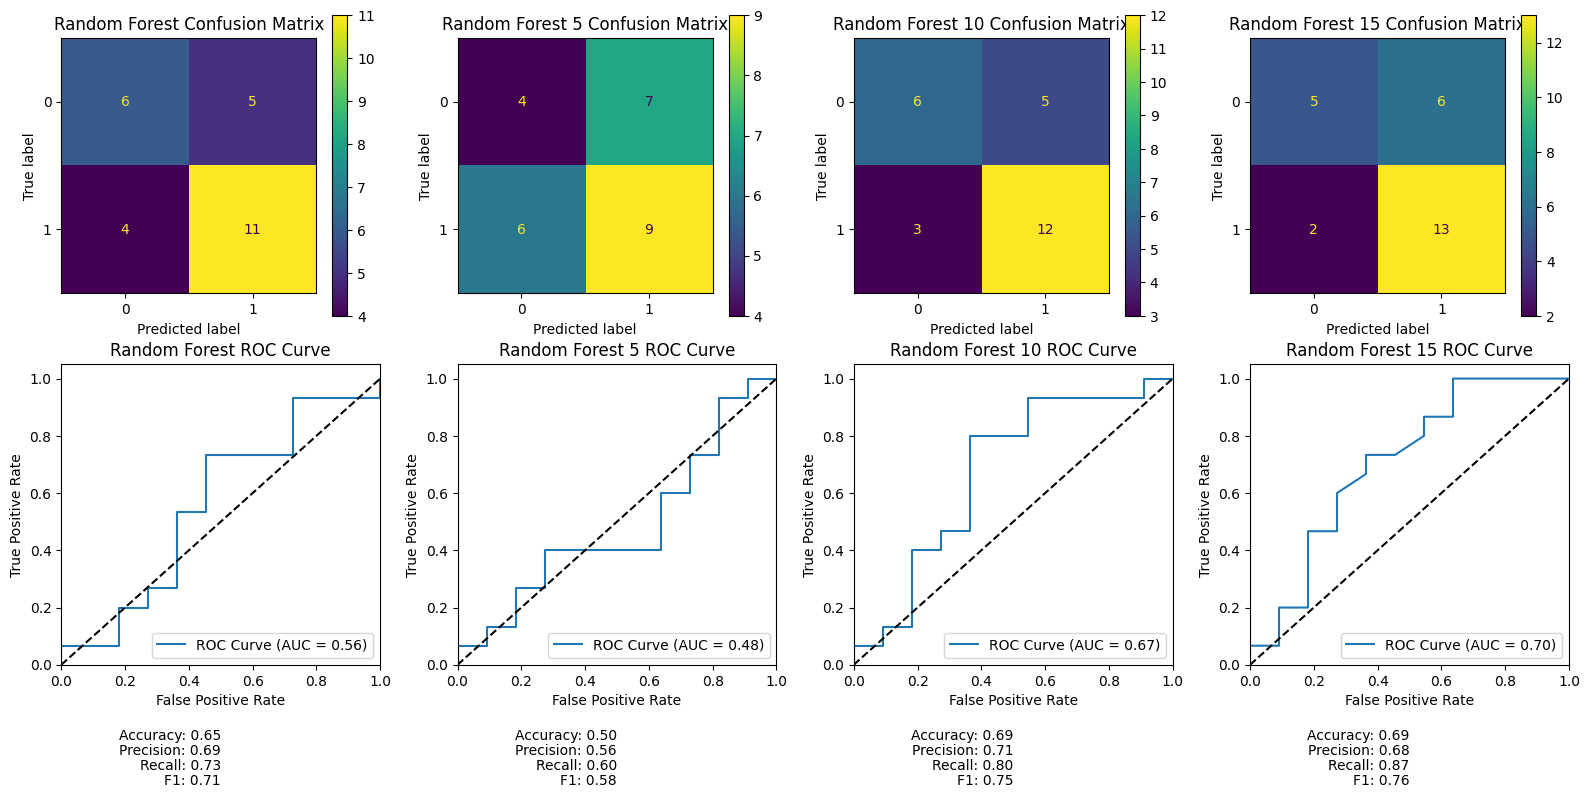

In [22]:
# Visual Method

# Initialize the models
models = [
    RandomForestClassifier(random_state=random_state),
    RandomForestClassifier(random_state=random_state, min_samples_leaf= 5),
    RandomForestClassifier(random_state=random_state, min_samples_leaf= 10),
    RandomForestClassifier(random_state=random_state, min_samples_leaf= 15)
]

# Define the model names for labeling
model_names = [
    'Random Forest',
    'Random Forest 5',
    'Random Forest 10',
    'Random Forest 15'
]

runModels(models, model_names, x_train, x_test, y_train, y_test)

### Number of Trees

Best parameters: {'n_estimators': 10}
Best score: 0.62


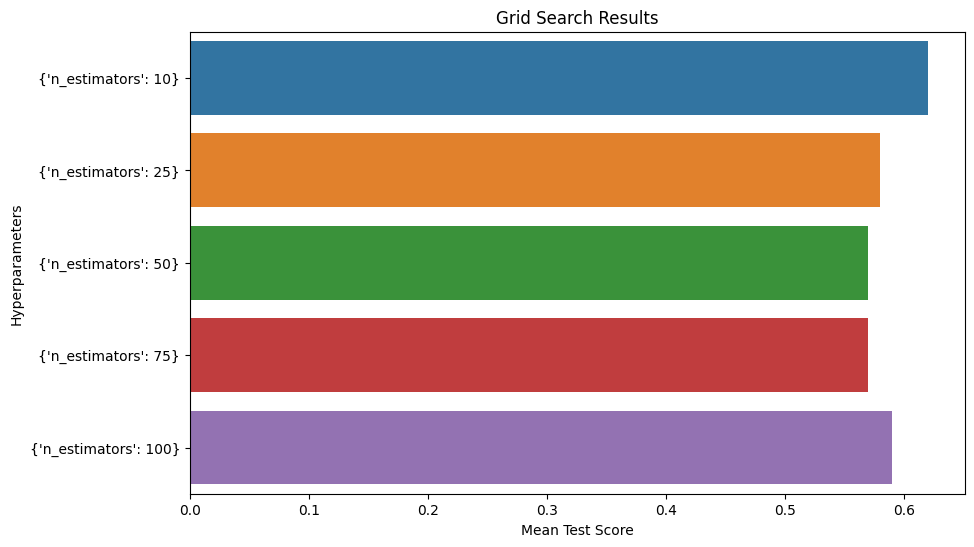

In [23]:
# Grid Search Method

# Create a Random Forest classifier object
model = RandomForestClassifier(random_state=random_state)

# Define the parameter grid
param_grid = {
    'n_estimators': [10, 25, 50, 75, 100]
}

# Perform grid search optimization
optimized_model = perform_grid_search(model, param_grid, x_train, y_train, plot=True)

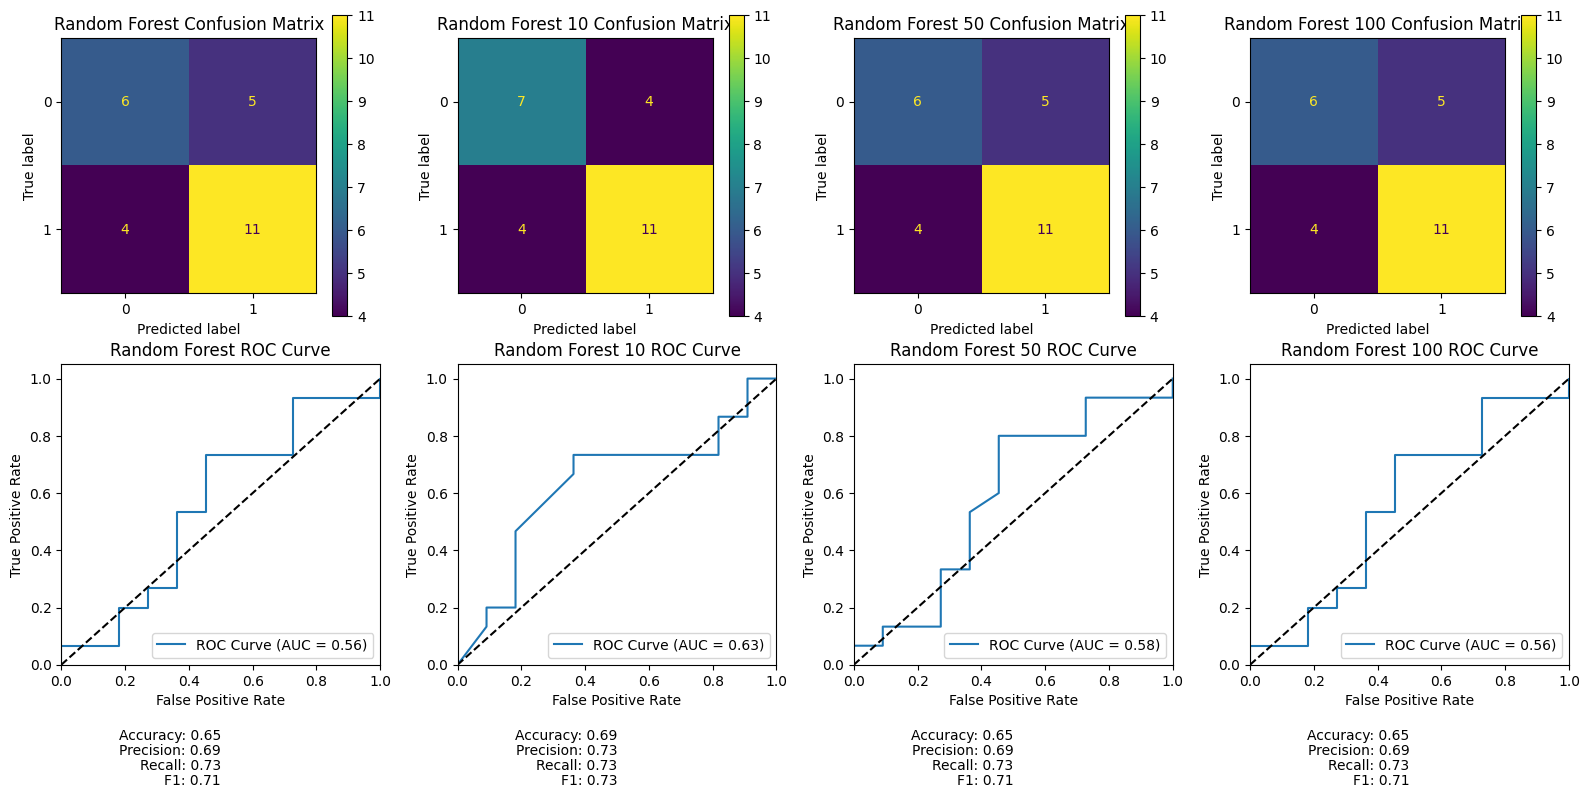

In [24]:
# Visual Method

# Initialize the models
models = [
    RandomForestClassifier(random_state=random_state),
    RandomForestClassifier(random_state=random_state, n_estimators= 10),
    RandomForestClassifier(random_state=random_state, n_estimators= 50),
    RandomForestClassifier(random_state=random_state, n_estimators= 100)
]

# Define the model names for labeling
model_names = [
    'Random Forest',
    'Random Forest 10',
    'Random Forest 50',
    'Random Forest 100'
]

runModels(models, model_names, x_train, x_test, y_train, y_test)

### Minimum Samples Split

Best parameters: {'min_samples_split': 2}
Best score: 0.59


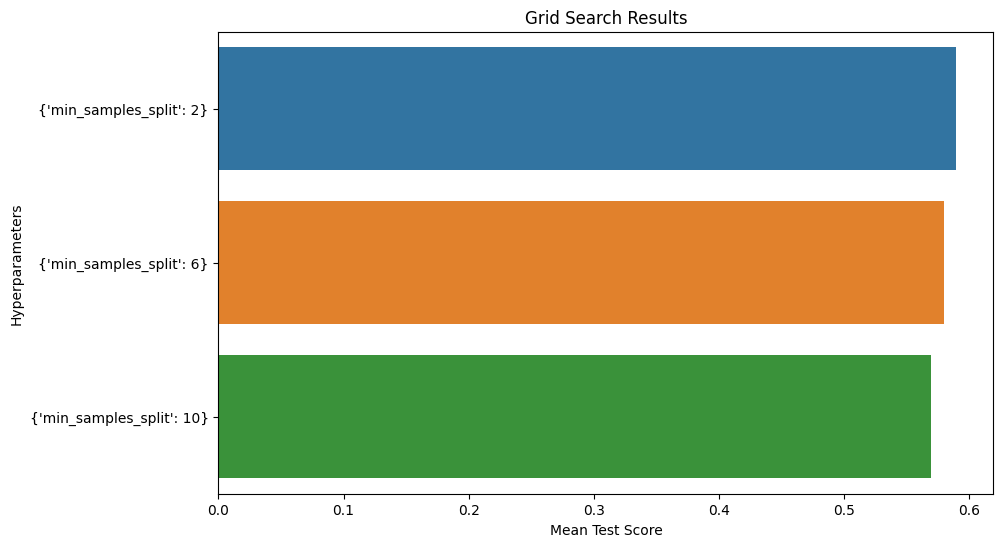

In [25]:
# Grid Search Method

# Create a Random Forest classifier object
model = RandomForestClassifier(random_state=random_state)

# Define the parameter grid
param_grid = {
    'min_samples_split': [2, 6, 10]
}

# Perform grid search optimization
optimized_model = perform_grid_search(model, param_grid, x_train, y_train, plot=True)

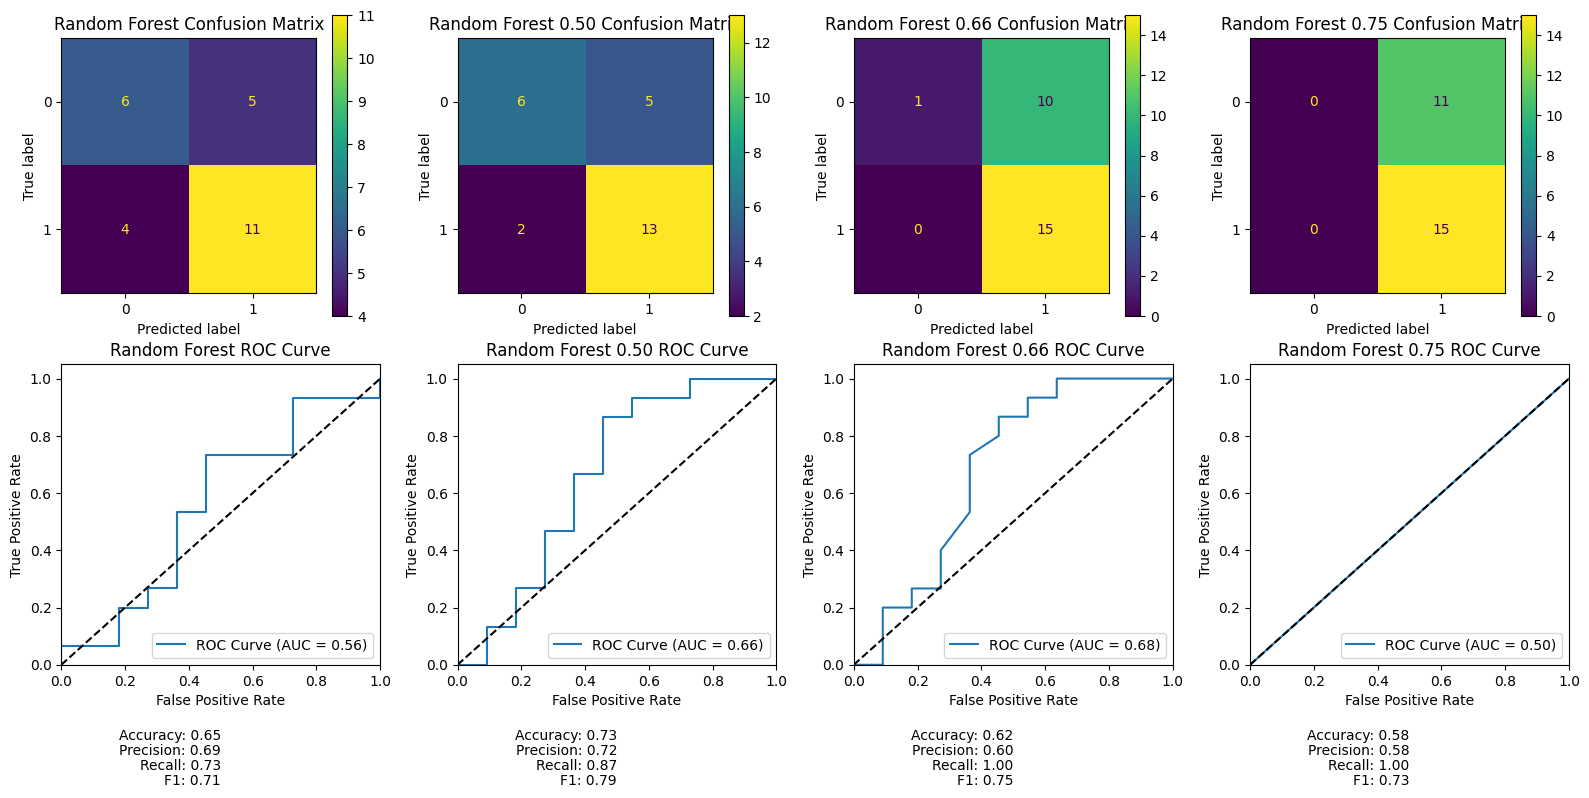

In [26]:
# Visual Method

# Initialize the models
models = [
    RandomForestClassifier(random_state=random_state),
    RandomForestClassifier(random_state=random_state, min_samples_split= 0.50),
    RandomForestClassifier(random_state=random_state, min_samples_split= 0.66),
    RandomForestClassifier(random_state=random_state, min_samples_split= 0.75)
]

# Define the model names for labeling
model_names = [
    'Random Forest',
    'Random Forest 0.50',
    'Random Forest 0.66',
    'Random Forest 0.75'
]

runModels(models, model_names, x_train, x_test, y_train, y_test)

### Max Depth

Best parameters: {'max_depth': 10}
Best score: 0.59


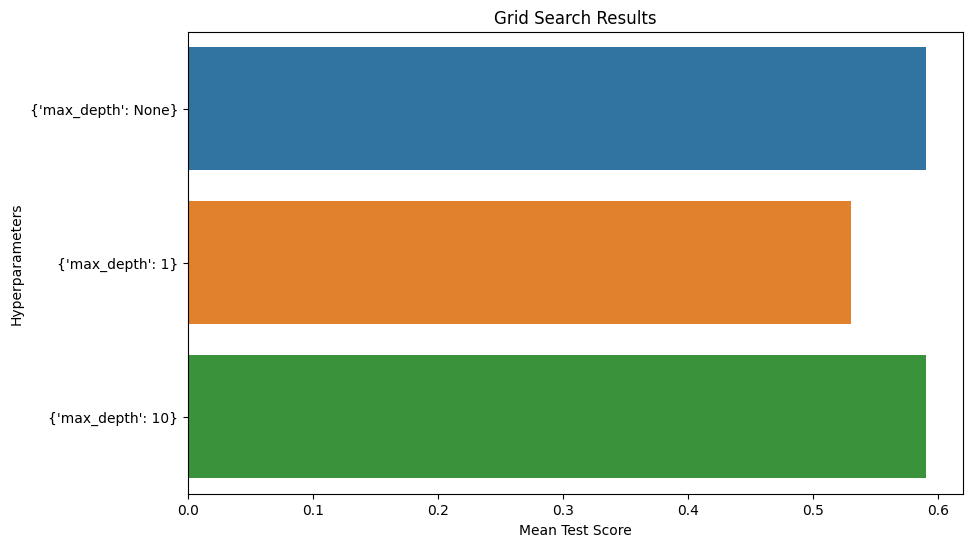

In [27]:
# Grid Search Method

# Create a Random Forest classifier object
model = RandomForestClassifier(random_state=random_state)

# Define the parameter grid
param_grid = {
    'max_depth': [None, 1, 10]
}

# Perform grid search optimization
optimized_model = perform_grid_search(model, param_grid, x_train, y_train, plot=True)

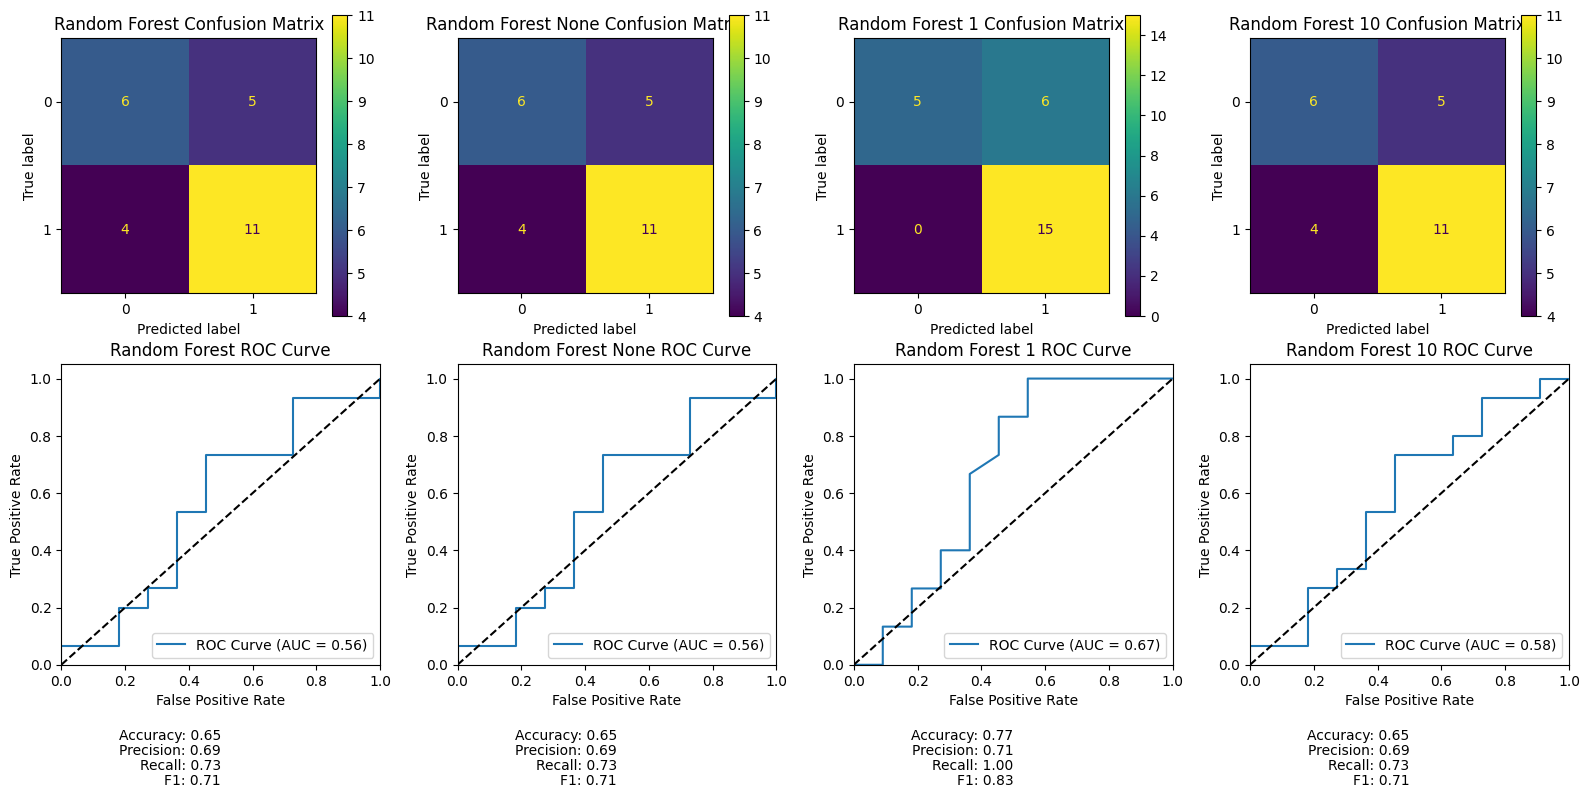

In [28]:
# Visual Method

# Initialize the models
models = [
    RandomForestClassifier(random_state=random_state),
    RandomForestClassifier(random_state=random_state, max_depth= None),
    RandomForestClassifier(random_state=random_state, max_depth= 1),
    RandomForestClassifier(random_state=random_state, max_depth= 10)
]

# Define the model names for labeling
model_names = [
    'Random Forest',
    'Random Forest None',
    'Random Forest 1',
    'Random Forest 10'
]

runModels(models, model_names, x_train, x_test, y_train, y_test)

### Applied Optimizations

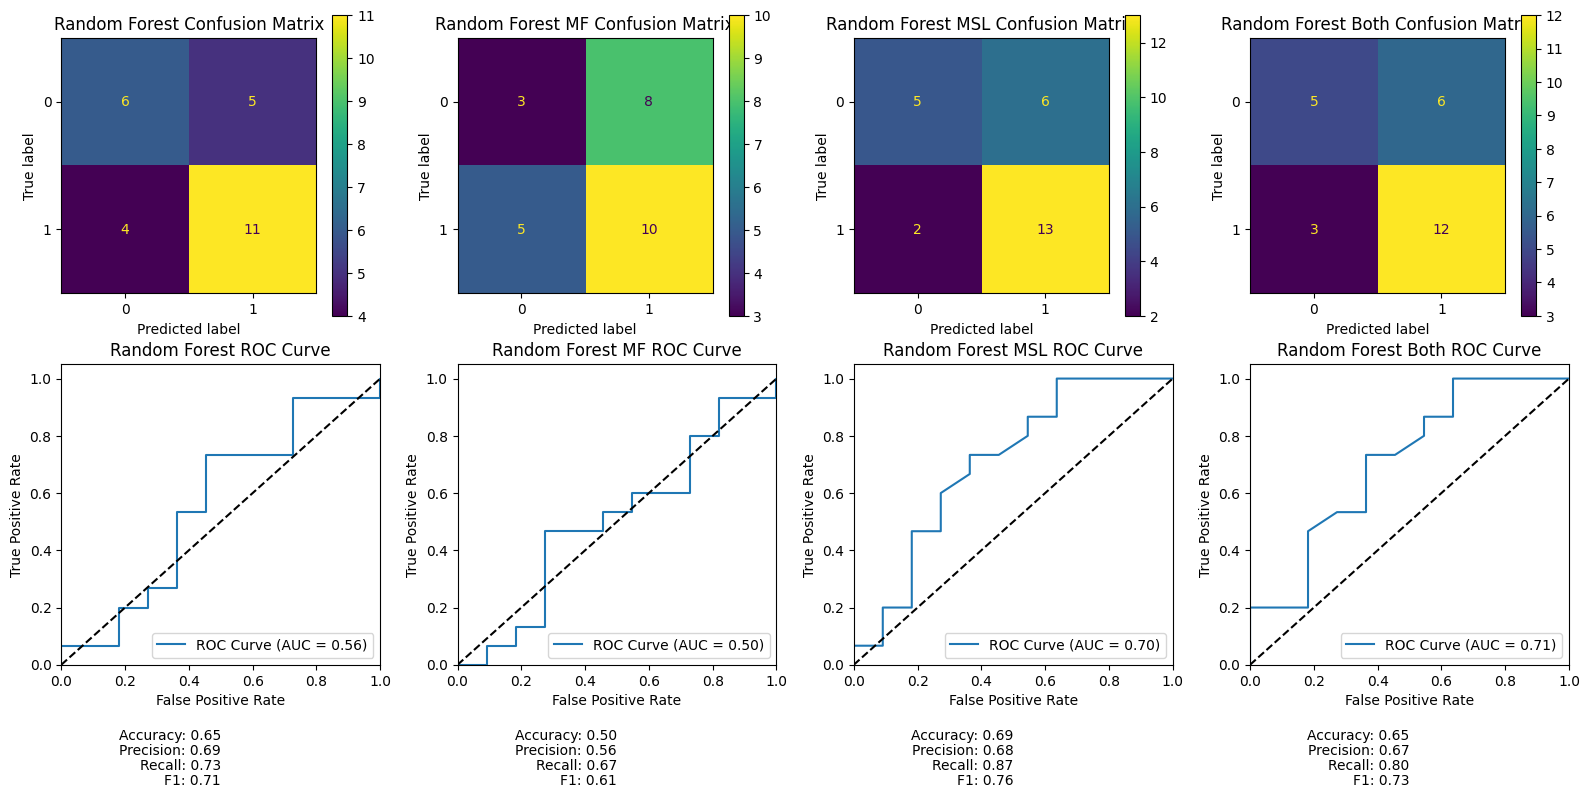

In [29]:
# Initialize the models
models = [
    RandomForestClassifier(random_state=random_state),
    RandomForestClassifier(random_state=random_state, max_features= 0.5),
    RandomForestClassifier(random_state=random_state, min_samples_leaf= 15),
    RandomForestClassifier(random_state=random_state, max_features= 0.5, min_samples_leaf= 15)
]

# Define the model names for labeling
model_names = [
    'Random Forest',
    'Random Forest MF',
    'Random Forest MSL',
    'Random Forest Both'
]

runModels(models, model_names, x_train, x_test, y_train, y_test)

#### Analysis

Each optimization adds up to positively increase our prediction metrics. Given this positive proof-of-concept, the next step will be to include more optimizations, relying on the automated attempts.

### Run More Optimizations

- Number of Trees
- Max Features
- Min Samples Split
- Minimum Samples Leaf
- Max Depth

In [30]:
# Grid Search Method

# Create a Random Forest classifier object
model = RandomForestClassifier(random_state=random_state)

# Define the parameter grid
param_grid = {
    'n_estimators': [10, 100],  # Number of trees
    'max_features': ['sqrt', None],  # Maximum features
    'min_samples_split': [2, 6],  # Minimum samples split
    'min_samples_leaf': [1, 5],  # Minimum samples leaf
    'max_depth': [None, 1]  # Maximum depth
}

# Perform grid search optimization
optimized_model = perform_grid_search(model, param_grid, x_train, y_train)

Best parameters: {'max_depth': None, 'max_features': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 10}
Best score: 0.67


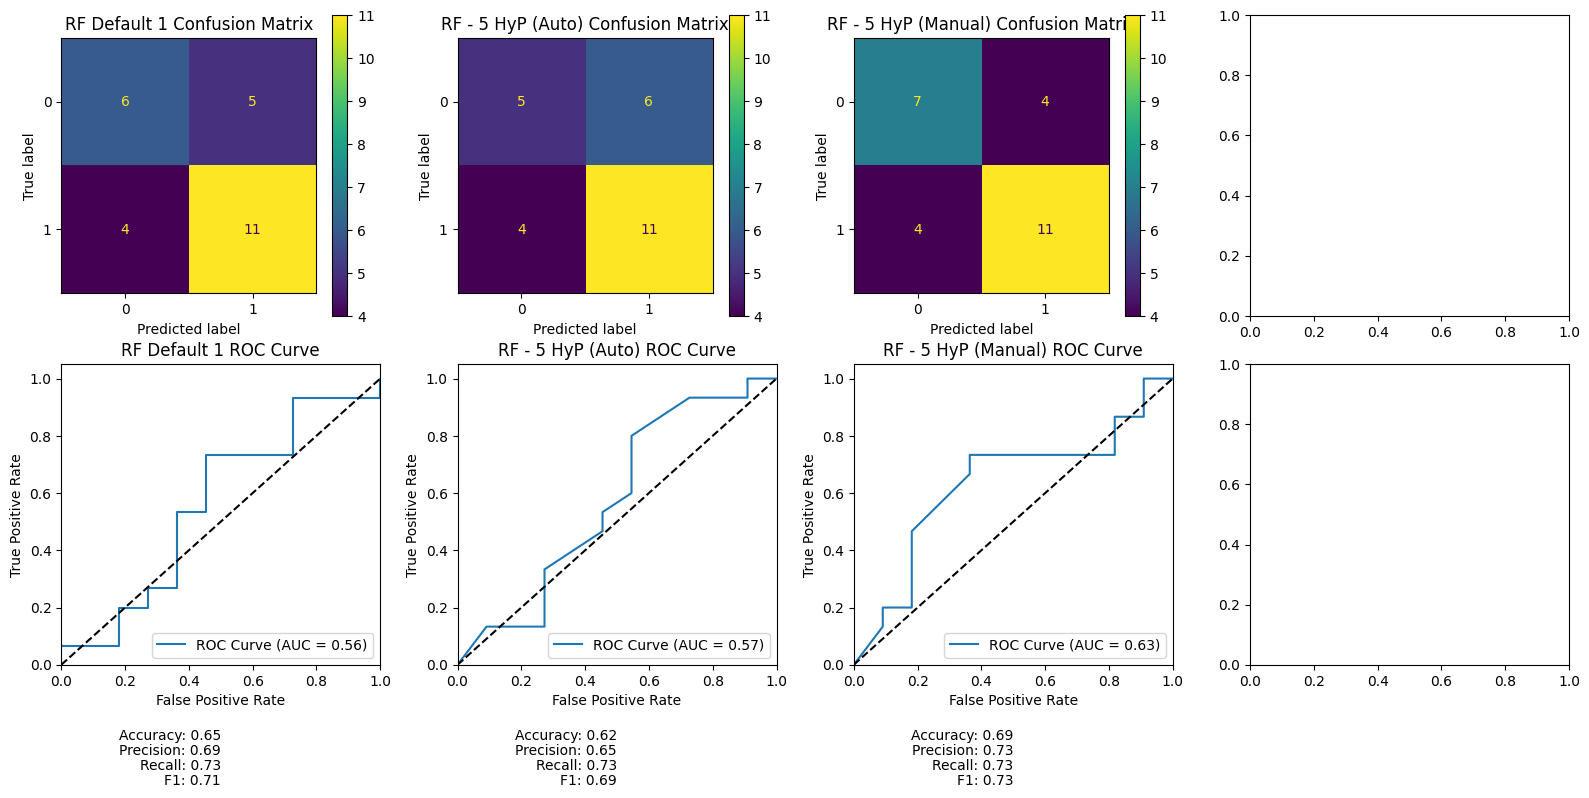

In [31]:
# Initialize the models
models = [
    RandomForestClassifier(random_state=random_state),
    #RandomForestClassifier(random_state=random_state, max_features='sqrt', min_samples_leaf= 1, n_estimators= 100, min_samples_split= 2, max_depth= None),
    optimized_model,
    RandomForestClassifier(random_state=random_state, max_features= 'sqrt', n_estimators= 10)
]

# Define the model names for labeling
model_names = [
    'RF Default 1',
    #'RF Default 2',
    'RF - 5 HyP (Auto)',
    'RF - 5 HyP (Manual)'
]

runModels(models, model_names, x_train, x_test, y_train, y_test)

#### Analysis

When tuning 5 parameters, the results generally worsen.

**Question:** Why might this be?

# Optimization - Automatic

## Bayesian Setup (hyperopt)

In [46]:
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
from sklearn.model_selection import cross_val_score

# Define the function to optimize
def optimize(params, x, y, model):
    model.set_params(**params)
    score = cross_val_score(model, x, y, cv=5).mean()
    return {'loss': -score, 'status': STATUS_OK}

# Define the parameter space
space_rf = {
    'n_estimators': hp.choice('n_estimators', range(10, 1000)),
    'max_depth': hp.choice('max_depth', range(1, 50)),
    'min_samples_split': hp.choice('min_samples_split', range(2, 11)),
    'min_samples_leaf': hp.choice('min_samples_leaf', range(1, 11)),
    'max_features': hp.choice('max_features', ['sqrt', 'log2']),
}

space_log_reg = {
    'C': hp.loguniform('C', -5, 3),
    'penalty': hp.choice('penalty', ['none', 'l2']),
}

# Optimize
random_forest = RandomForestClassifier()
best_rf = fmin(fn=lambda params: optimize(params, x_train, y_train, random_forest), 
               space=space_rf, algo=tpe.suggest, 
               max_evals=100, trials=Trials())

log_reg = LogisticRegression()
best_log_reg = fmin(fn=lambda params: optimize(params, x_train, y_train, log_reg), 
                    space=space_log_reg, algo=tpe.suggest, 
                    max_evals=100, trials=Trials())

print("Optimized Random Forest parameters: ", best_rf)
print("Optimized Logistic Regression parameters: ", best_log_reg)

  3%|▎         | 3/100 [00:00<00:04, 22.40trial/s, best loss: -0.54]

c:\Users\danie\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(

c:\Users\danie\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(

c:\Users\danie\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(

c:\Users\danie\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(

c:\Users\danie\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_

  9%|▉         | 9/100 [00:00<00:04, 22.33trial/s, best loss: -0.54]

c:\Users\danie\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(

c:\Users\danie\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(

c:\Users\danie\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(

c:\Users\danie\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(

c:\Users\danie\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_

 15%|█▌        | 15/100 [00:00<00:03, 23.85trial/s, best loss: -0.55]

c:\Users\danie\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(

c:\Users\danie\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(

c:\Users\danie\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(

c:\Users\danie\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(

c:\Users\danie\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_

 21%|██        | 21/100 [00:00<00:03, 24.75trial/s, best loss: -0.55]

c:\Users\danie\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(

c:\Users\danie\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(

c:\Users\danie\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(

c:\Users\danie\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(

c:\Users\danie\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_

 45%|████▌     | 45/100 [00:01<00:02, 24.98trial/s, best loss: -0.57]

c:\Users\danie\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(

c:\Users\danie\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(

c:\Users\danie\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(

c:\Users\danie\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(

c:\Users\danie\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_

 48%|████▊     | 48/100 [00:01<00:02, 24.38trial/s, best loss: -0.57]

c:\Users\danie\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(

c:\Users\danie\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(

c:\Users\danie\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(

c:\Users\danie\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(

c:\Users\danie\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_

 54%|█████▍    | 54/100 [00:02<00:02, 22.48trial/s, best loss: -0.57]

c:\Users\danie\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(

c:\Users\danie\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(

c:\Users\danie\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(

c:\Users\danie\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(

c:\Users\danie\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_

 63%|██████▎   | 63/100 [00:02<00:01, 24.58trial/s, best loss: -0.57]

c:\Users\danie\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(

c:\Users\danie\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(

c:\Users\danie\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(

c:\Users\danie\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(

c:\Users\danie\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_

 69%|██████▉   | 69/100 [00:02<00:01, 25.64trial/s, best loss: -0.57]

c:\Users\danie\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(

c:\Users\danie\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(



 84%|████████▍ | 84/100 [00:03<00:00, 25.68trial/s, best loss: -0.57]

c:\Users\danie\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(

c:\Users\danie\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(

c:\Users\danie\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(

c:\Users\danie\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(

c:\Users\danie\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_

 87%|████████▋ | 87/100 [00:03<00:00, 24.36trial/s, best loss: -0.57]

c:\Users\danie\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(

c:\Users\danie\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(

c:\Users\danie\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(

c:\Users\danie\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(

c:\Users\danie\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_

 96%|█████████▌| 96/100 [00:03<00:00, 21.85trial/s, best loss: -0.57]

c:\Users\danie\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(

c:\Users\danie\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(

c:\Users\danie\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(

c:\Users\danie\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(

c:\Users\danie\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_

100%|██████████| 100/100 [00:04<00:00, 24.17trial/s, best loss: -0.57]
Optimized Random Forest parameters:  {'max_depth': 25, 'max_features': 0, 'min_samples_leaf': 3, 'min_samples_split': 4, 'n_estimators': 177}
Optimized Logistic Regression parameters:  {'C': 0.016711076588345496, 'penalty': 1}


c:\Users\danie\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(

c:\Users\danie\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(

c:\Users\danie\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(

c:\Users\danie\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(

c:\Users\danie\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_

### Comparison

c:\Users\danie\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


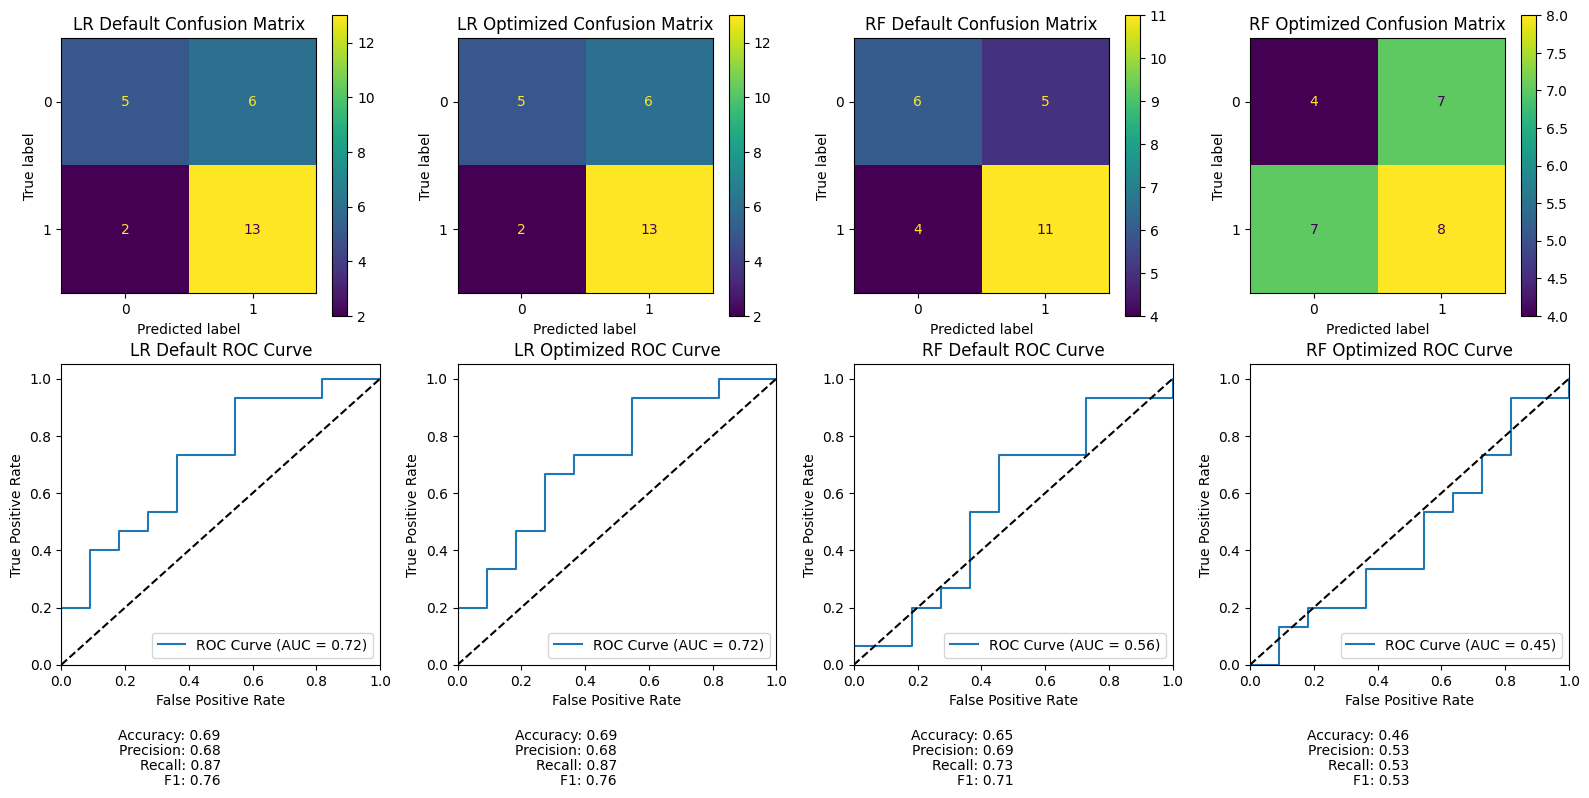

In [51]:
# Initialize the models
models = [
    LogisticRegression(random_state=random_state),
    LogisticRegression(random_state=random_state, C= 0.016711076588345496, penalty= None),
    RandomForestClassifier(random_state=random_state),
    RandomForestClassifier(random_state=random_state, max_depth= 25, max_features=  None, min_samples_leaf= 3, min_samples_split=4, n_estimators=177)
]

# Define the model names for labeling
model_names = [
    'LR Default',
    'LR Optimized',
    'RF Default',
    'RF Optimized'
]

runModels(models, model_names, x_train, x_test, y_train, y_test)